# Прогнозирование оттока клиентов для оператора связи

## Обзор данных 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import phik
import seaborn as sns
from phik.report import plot_correlation_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import sklearn
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn import svm
import optuna
from optuna.samplers import RandomSampler
RANDOM_STATE = 311022
sampler = RandomSampler(seed=RANDOM_STATE)
from sklearn.model_selection import cross_val_score
import phik
import seaborn as sns
from phik.report import plot_correlation_matrix

In [2]:
ct = pd.read_csv('/datasets/final_provider/contract.csv')

In [3]:
it = pd.read_csv('/datasets/final_provider/internet.csv')

In [4]:
pl = pd.read_csv('/datasets/final_provider/personal.csv')

In [5]:
pe = pd.read_csv('/datasets/final_provider/phone.csv')

Посмотрим на данные для ознакомления, для этого создадим функцию. 

In [6]:
def gen_inform(dataset):
    display(dataset.info())
    display(dataset.head())
    display(dataset.describe())
    display(dataset.describe(include=['object', 'bool']))
    print('Количество уникальных значений')
    display(dataset.nunique())
    print('Количество дубликатов')
    display(dataset.duplicated().sum())

In [7]:
gen_inform(ct)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,TotalCharges
count,7043,7043,7043,7043,7043,7043,7043
unique,7043,77,5,3,2,4,6531
top,8679-JOEVF,2014-02-01,No,Month-to-month,Yes,Electronic check,20.2
freq,1,366,5174,3875,4171,2365,11


Количество уникальных значений


customerID          7043
BeginDate             77
EndDate                5
Type                   3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
dtype: int64

Количество дубликатов


0

In [8]:
gen_inform(it)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,3259-KNMRR,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,3259-KNMRR,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


Количество уникальных значений


customerID          5517
InternetService        2
OnlineSecurity         2
OnlineBackup           2
DeviceProtection       2
TechSupport            2
StreamingTV            2
StreamingMovies        2
dtype: int64

Количество дубликатов


0

In [9]:
gen_inform(pl)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


,customerID,gender,Partner,Dependents
count,7043,7043,7043,7043
unique,7043,2,2,2
top,8679-JOEVF,Male,No,No
freq,1,3555,3641,4933


Количество уникальных значений


customerID       7043
gender              2
SeniorCitizen       2
Partner             2
Dependents          2
dtype: int64

Количество дубликатов


0

In [10]:
gen_inform(pe)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,8679-JOEVF,No
freq,1,3390


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,8679-JOEVF,No
freq,1,3390


Количество уникальных значений


customerID       6361
MultipleLines       2
dtype: int64

Количество дубликатов


0

Всего в нашем распоряжении 4 таблицы: 
1) Contract (ct) Вcего 7043 строки и 8 столбцов. В таблице содержится следующая информация:
- customerID - идентификационный номер клиента
- BeginDate	- дата начала пользования услугами
- EndDate - дата окончания окончания пользования услугами
- Type - тип срока оплаты (ежемесячно, раз в год, раз в два года)
- PaperlessBilling - тип выставления счета (бумажный или электронный)
- PaymentMethod	- метод оплаты (Electronic check, Mailed check, Bank Transfer(automatic), Credit Card(automatic)
- MonthlyCharges - ежемесячная оплата
- TotalCharges - общая сумма оплат

2) Internet (it) Всего 5517 строк и 8тстолбцов. В таблице содержится следующая информация:
- customerID - идентификационный номер клиента
- InternetService - тип интрнет подключения
- OnlineSecurity - блокировка небезопасных сайтов
- OnlineBackup - облачное храненилище файлов для резервного копирования данных
- DeviceProtection - интернет безопасность
- TechSupport -выделенная линия технической поддержки
- StreamingTV - стриминговое телевидение
- StreamingMovies - каталог фильмов 

3) Personal (pl) Всего 7043 строк и 5 столбцов. В таблице содержится следующая информация:
- customerID - идентификационный номер клиента
- gender - пол
- SeniorCitizen - является ли клиент пенсионного возраста
- Partner - есть ли партнер
- Dependents - есть ли кто-то на иждивении

4) Phone (pe) Всего 6361 строка и 2 столбца. В таблице содержится следующая информация:
- customerID - идентификационный номер клиента
- MultipleLines - подключен ли телефонный аппарат  к нескольким линиям одновременно. 

Исходя из тех данных, которые мы сейчас видим, можно сделать следующие выводы:
Пропусков нигде нет. 
В двух таблицах (Contract и Personal) одинаковое кол-во строк 7043, соответственно мы имеем данные о 7043-х клиентах компании. Кол-во клиентов, которые пользуются только услугами интрнет составляет 5517, а кол-во тех, кто пользуется услугами только телефонной связи составляет 6361.
Необходимо сделать предобработку данных: 

- В некоторых столбцах неверный тип данных, нужно изменить на правильный. 
- Стоит проверить данные на аномалии. 

Перед нами стоит задача спрогнозирровать отток клиентов. Целевой признак в нашем случае - ушел клиент (есть дата окончания пользования услугами) или остался. Для удобства дальнейшей работы нужно создать дополнительный столбец, который будет содержать информацию о том, является ли клиент до сих пор пользователем услугами (0) или же клиент ушел (1). 
Стоит провести исследовательский анализ данных:
Отток клиентов может быть обусловлен внутренними и внешними факторами. Есть и естественный отток клиентов в конкурентной среде. Для более четкого понимания посмотрим на следующее:
- Ротация клиентов по месяцам
- Соотношение услуг, которыми пользуются клиенты 
- Через сколько месяцев клиенты расторгали договор с компанией. 

Перед построением модели нужно посмотреть на распределение ушедших клиентов и оставшихся, чтобы проконтролировать баланс классов для лучшего прогнозирования.
Также, у нас есть строковые данные, которые надо будет закодировать.  

## Исследовательский анализ данных

Так как перед нами стоит задача спрогнозировать отток клиентов, то для этой цели следует создать столбец с целевым признаком: 0 и 1 (1 - клиент ушел, 0 - клиент остался).

In [11]:
ct['Exited'] = ct.apply(lambda x: 0 if x.EndDate == 'No' else 1, axis=1)

В столбце TotalCharges тип данных object. Посмотрим более детально. 

In [12]:
ct['TotalCharges'].unique()

array(['29.85', '1889.5', '108.15', ..., '346.45', '306.6', '6844.5'],
      dtype=object)

In [13]:
ct['TotalCharges'].unique().min()

' '

In [14]:
ct.loc[ct.loc[:, 'TotalCharges'] == ' ']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Exited
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,,0
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,,0
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,,0
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,,0
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,,0
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,,0
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,,0
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,,0
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,,0
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,,0


Не проставлены значения только в тех случаях, когда дата начала договора приходится на 1 февраля, видимо еще не было оплат. Так как оплат не было, то пустые значения можно заменить на 0.

In [15]:
ct['TotalCharges'] = ct['TotalCharges'].replace(' ', 0)
ct['TotalCharges'] = pd.to_numeric(ct['TotalCharges'])

В столбце с датой окончания договора присутсвует 'No'. Создадим заглушку с датой актуальности данных: 01.02.2020

In [16]:
ct['EndDate'] = ct['EndDate'].replace(['No'], ['2020-02-01'])
print(ct[ct['EndDate'] == 'No'].shape[0])

0


Изменим тип данных в столбцах BeginDate и EndDate

In [17]:
ct['BeginDate'] = pd.to_datetime(ct['BeginDate'], format='%Y-%m-%d')
ct['EndDate'] = pd.to_datetime(ct['EndDate'], format='%Y-%m-%d')

Для дальнейших расчетов понадобится столбец с кол-вом дней, в течении кторорых клиент пользовался услугами компании. 

In [18]:
# Создадим столбец 
ct['TotalDays'] = (ct['EndDate'] - ct['BeginDate']).dt.days

Проверим как изменились данные 

In [19]:
ct.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   Exited            7043 non-null   int64         
 9   TotalDays         7043 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(2), object(4)
memory usage: 550.4+ KB


Объединим все 4 таблицы в одну 

In [20]:
df = ct \
    .merge(pl, how='left', on='customerID') \
    .merge(it, how='left', on='customerID') \
    .merge(pe, how='left', on='customerID')

In [21]:
gen_inform(df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   Exited            7043 non-null   int64         
 9   TotalDays         7043 non-null   int64         
 10  gender            7043 non-null   object        
 11  SeniorCitizen     7043 non-null   int64         
 12  Partner           7043 non-null   object        
 13  Dependents        7043 non-null   object        
 14  InternetService   5517 n

None

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Exited,TotalDays,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,0,31,...,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,0,1036,...,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1,61,...,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,0,1371,...,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1,61,...,No,No,Fiber optic,No,No,No,No,No,No,No


,MonthlyCharges,TotalCharges,Exited,TotalDays,SeniorCitizen
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,64.761692,2279.734304,0.265370,985.996166,0.162147
std,30.090047,2266.794470,0.441561,747.587844,0.368612
min,18.250000,0.000000,0.000000,0.000000,0.000000
25%,35.500000,398.550000,0.000000,273.000000,0.000000
50%,70.350000,1394.550000,0.000000,883.000000,0.000000
75%,89.850000,3786.600000,1.000000,1676.000000,0.000000
max,118.750000,8684.800000,1.000000,2191.000000,1.000000


,customerID,Type,PaperlessBilling,PaymentMethod,gender,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
count,7043,7043,7043,7043,7043,7043,7043,5517,5517,5517,5517,5517,5517,5517,6361
unique,7043,3,2,4,2,2,2,2,2,2,2,2,2,2,2
top,8679-JOEVF,Month-to-month,Yes,Electronic check,Male,No,No,Fiber optic,No,No,No,No,No,No,No
freq,1,3875,4171,2365,3555,3641,4933,3096,3498,3088,3095,3473,2810,2785,3390


Количество уникальных значений


customerID          7043
BeginDate             77
EndDate                5
Type                   3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Exited                 2
TotalDays            156
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
InternetService        2
OnlineSecurity         2
OnlineBackup           2
DeviceProtection       2
TechSupport            2
StreamingTV            2
StreamingMovies        2
MultipleLines          2
dtype: int64

Количество дубликатов


0

После объединения образовались пропуски, что вполне логично, потому что есть клиенты, которые использует либо только телефонию, либо только интернет. Заменим пропуски на 'NS' - No Service

In [22]:
for column in ('InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines'):
    df[column] = df[column].fillna('NS')

Для удобства в дальнейшем создадим списки с категориальными и числовыми столбцами 

In [23]:
numeric_columns = ['MonthlyCharges', 'TotalCharges', 'TotalDays']
categorial_columns = ['Type','PaymentMethod','gender','SeniorCitizen','InternetService']

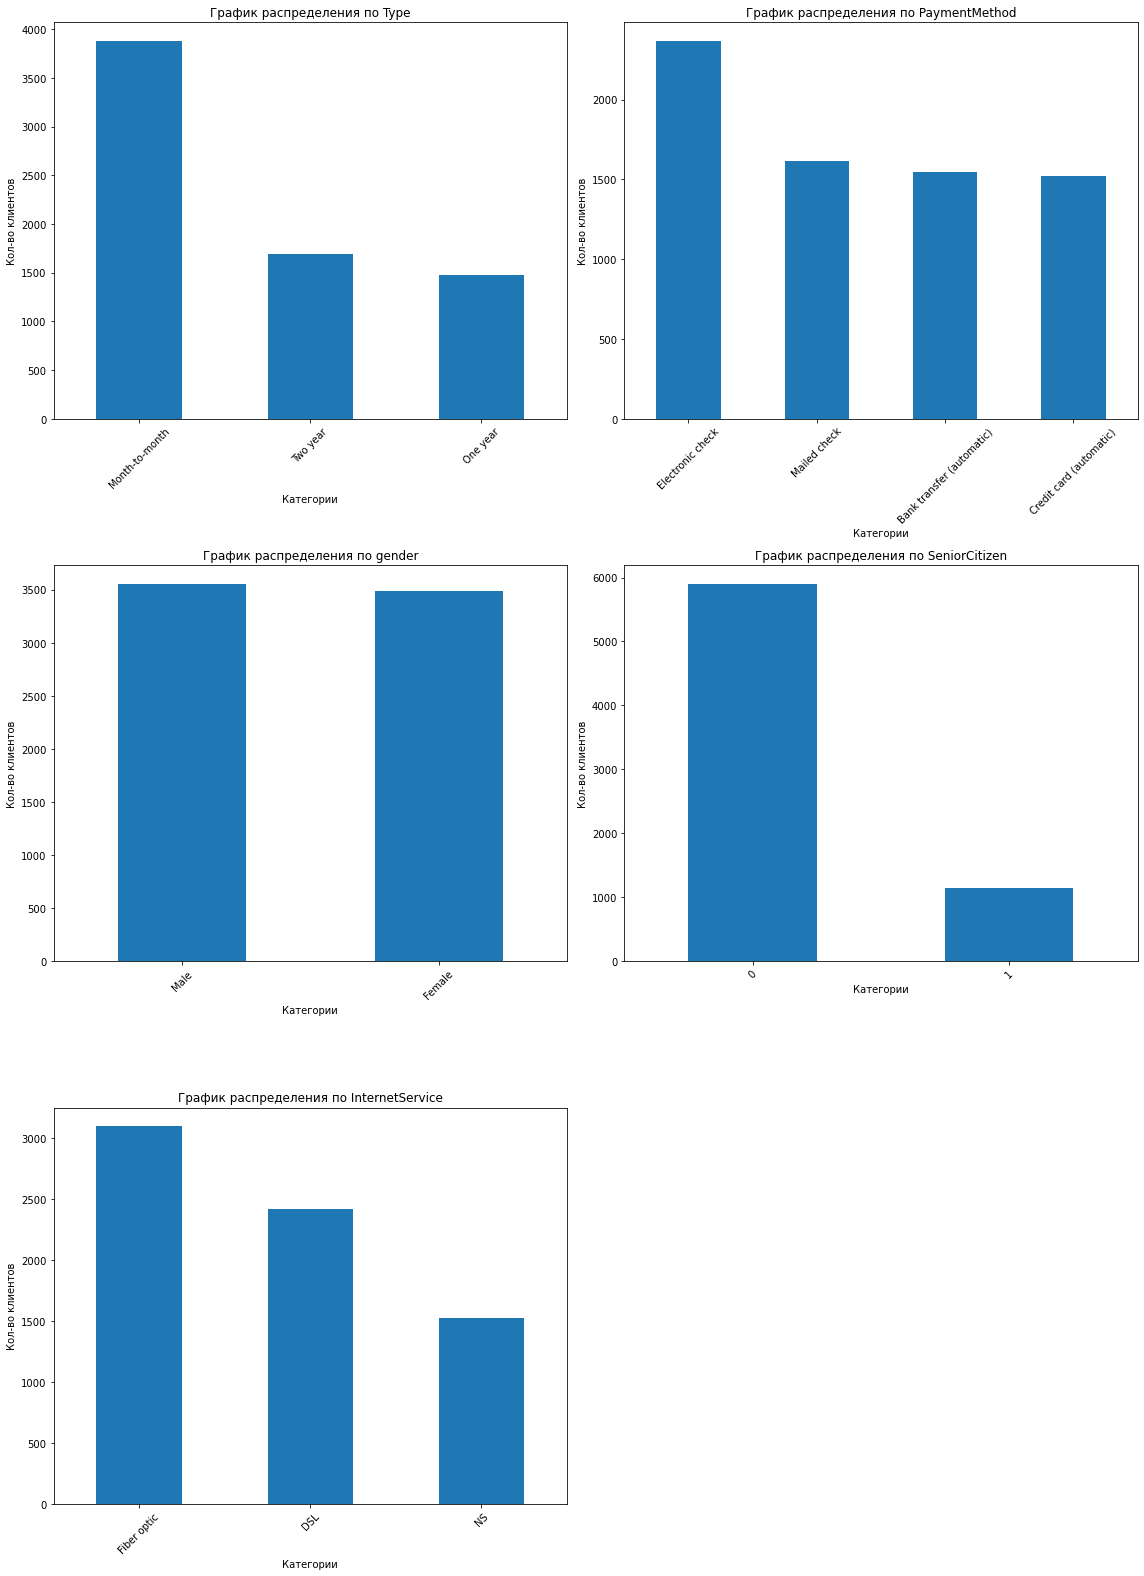

In [24]:
cols = 2
rows = 3

plt.figure(figsize=(16, 22))

for idx, column in enumerate(categorial_columns):
    ax = plt.subplot(rows, cols, idx + 1)
    
    df[column].value_counts().plot(
        kind='bar', 
        title='График распределения по ' + column,
        ylabel='Кол-во клиентов',
        xlabel='Категории',
        ax=ax,
        rot=45
    )
plt.tight_layout()
plt.show()

In [25]:
def dif_table(col_group):
    table1 = df.groupby(col_group, as_index=False)['Exited'].sum()
    table2 = df.groupby(col_group, as_index=False)['customerID'].count()
    merge = table1.merge(table2, on=col_group)
    merge.rename(columns = {'customerID':'all'}, inplace = True)
    merge['notExited'] = merge['all'] - merge['Exited']
    merge = merge.drop('all', axis=1)
    
    
      
    return merge

,Type,Exited,notExited
0,Month-to-month,1655,2220
1,One year,166,1307
2,Two year,48,1647


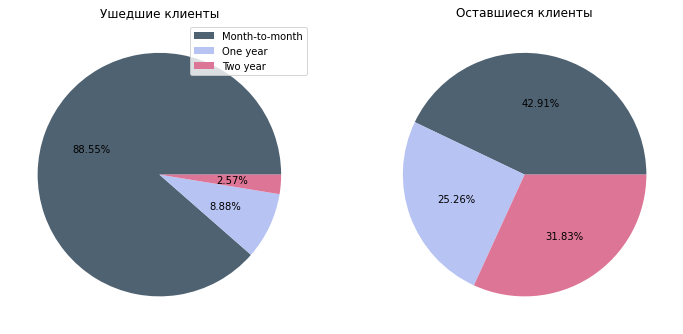

,PaperlessBilling,Exited,notExited
0,No,469,2403
1,Yes,1400,2771


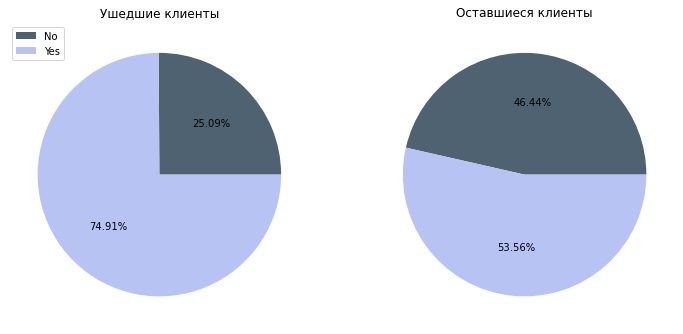

,PaymentMethod,Exited,notExited
0,Bank transfer (automatic),258,1286
1,Credit card (automatic),232,1290
2,Electronic check,1071,1294
3,Mailed check,308,1304


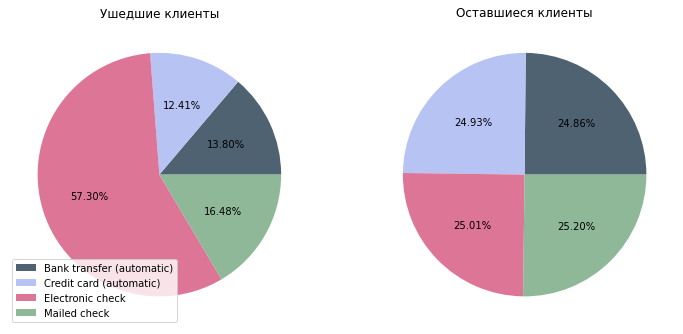

,gender,Exited,notExited
0,Female,939,2549
1,Male,930,2625


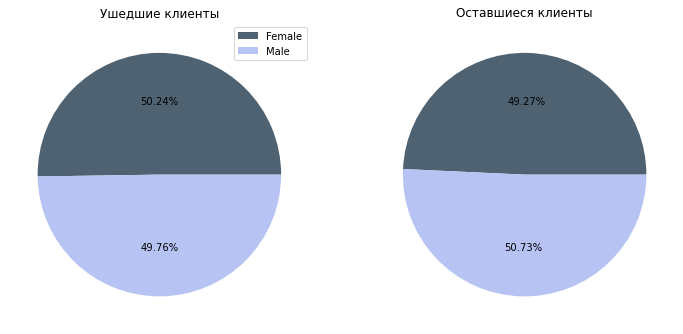

,SeniorCitizen,Exited,notExited
0,0,1393,4508
1,1,476,666


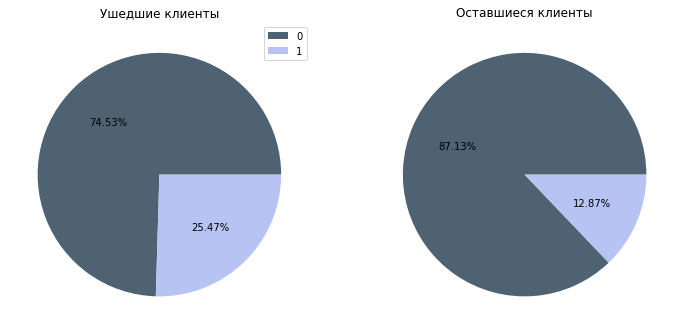

,Partner,Exited,notExited
0,No,1200,2441
1,Yes,669,2733


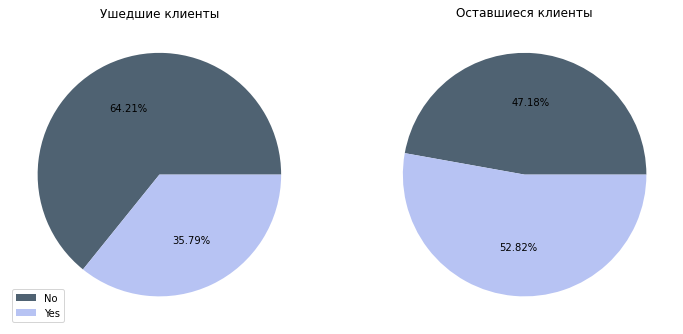

,Dependents,Exited,notExited
0,No,1543,3390
1,Yes,326,1784


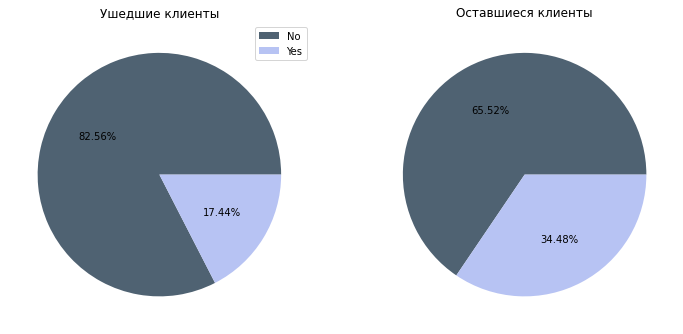

,InternetService,Exited,notExited
0,DSL,459,1962
1,Fiber optic,1297,1799
2,NS,113,1413


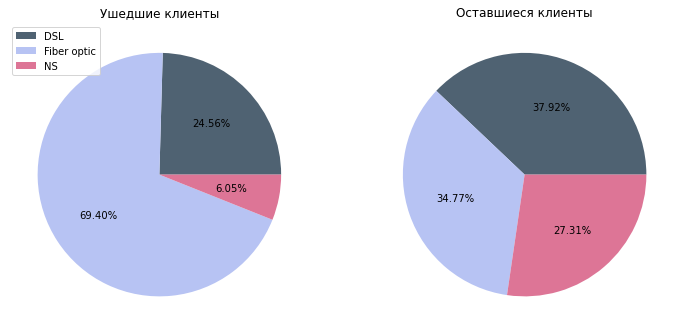

,OnlineSecurity,Exited,notExited
0,NS,113,1413
1,No,1461,2037
2,Yes,295,1724


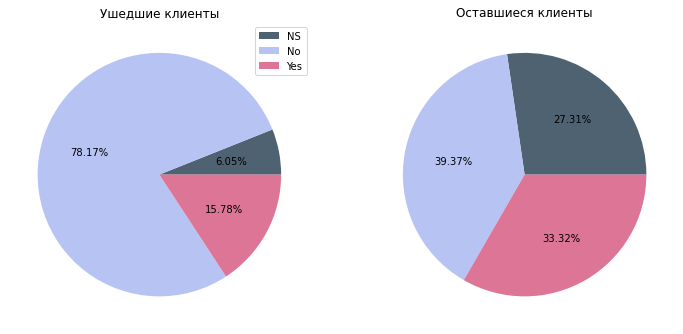

,OnlineBackup,Exited,notExited
0,NS,113,1413
1,No,1233,1855
2,Yes,523,1906


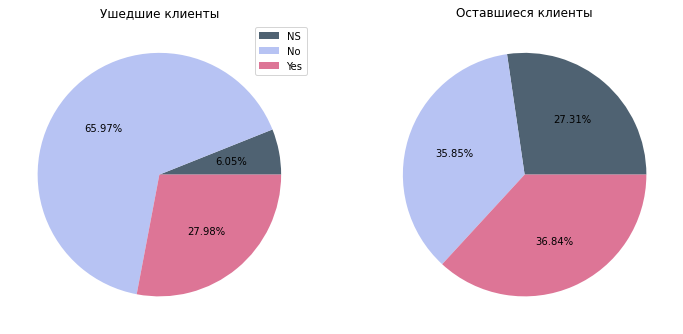

,DeviceProtection,Exited,notExited
0,NS,113,1413
1,No,1211,1884
2,Yes,545,1877


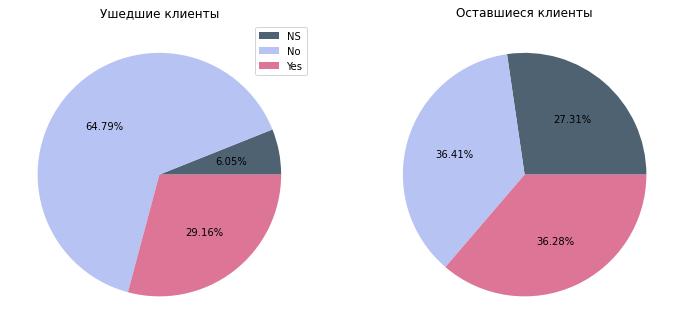

,TechSupport,Exited,notExited
0,NS,113,1413
1,No,1446,2027
2,Yes,310,1734


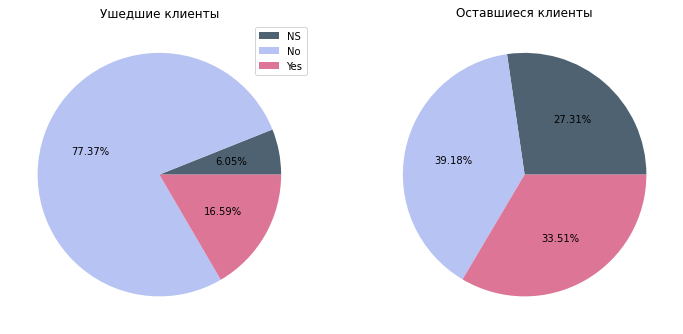

,StreamingTV,Exited,notExited
0,NS,113,1413
1,No,942,1868
2,Yes,814,1893


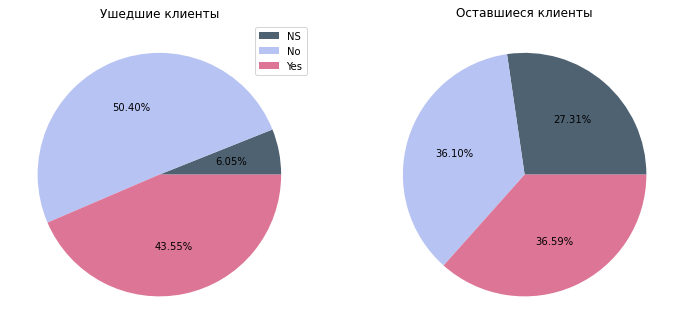

,StreamingMovies,Exited,notExited
0,NS,113,1413
1,No,938,1847
2,Yes,818,1914


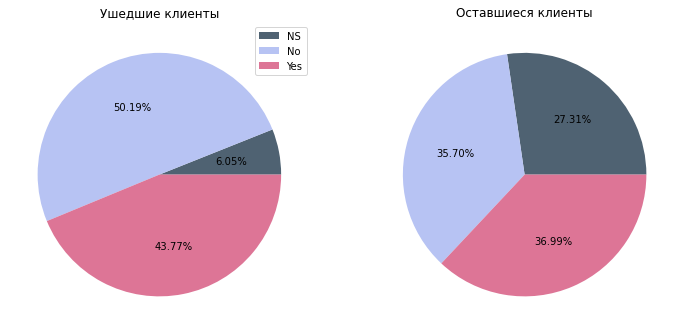

,MultipleLines,Exited,notExited
0,NS,170,512
1,No,849,2541
2,Yes,850,2121


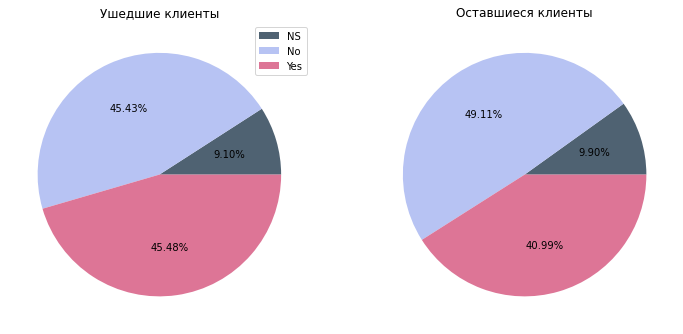

In [26]:
categorials_columns = ['Type','PaperlessBilling','PaymentMethod','gender','SeniorCitizen','Partner','Dependents','InternetService', 
    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']

for col in categorials_columns:
    udt = dif_table(col)
    display(udt)
    plt.figure(figsize=(12, 12))
    
    plt.subplot(1, 2, 1)
    colors = ['#4F6272', '#B7C3F3', '#DD7596', '#8EB897']
    plt.pie(udt['Exited'], autopct='%1.2f%%', colors=colors)
    plt.legend(labels=udt[col], loc='best')
    plt.title('Ушедшие клиенты')
   
    
    plt.subplot(1, 2, 2)
    plt.pie(udt['notExited'], autopct='%1.2f%%', colors=colors)
    plt.title('Оставшиеся клиенты')
    plt.show()

Посмотрим на кол-во новых клиентов компании по годам

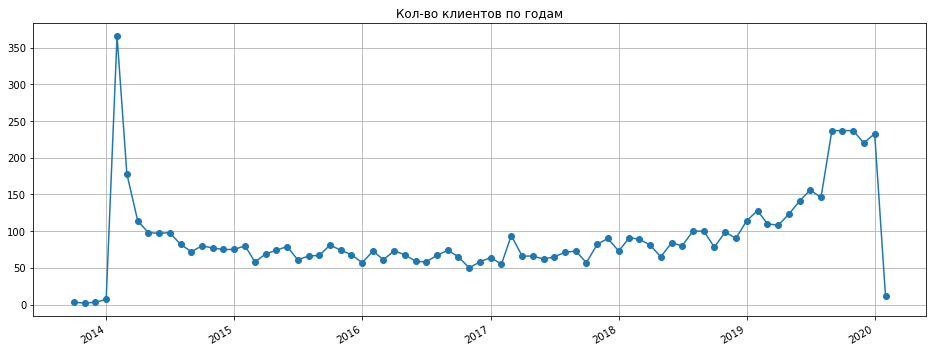

In [27]:
df['BeginDate'].value_counts().plot(style='o-', grid=True,figsize=(16, 6))
plt.title("Кол-во клиентов по годам")
plt.show()

Посмотрим на кол-во новых клиентов компании с 2019 года 

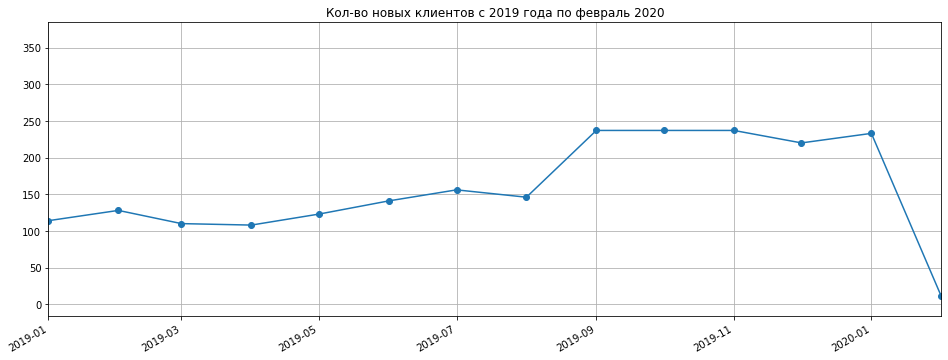

In [28]:
df['BeginDate'].value_counts().plot(style='o-',xlim = ('2019', '2020-02'), grid=True,figsize=(16, 6))
plt.title("Кол-во новых клиентов с 2019 года по февраль 2020")
plt.show()

Посмотрим на отток клиентов (заисимость от длительности пользования услугами)

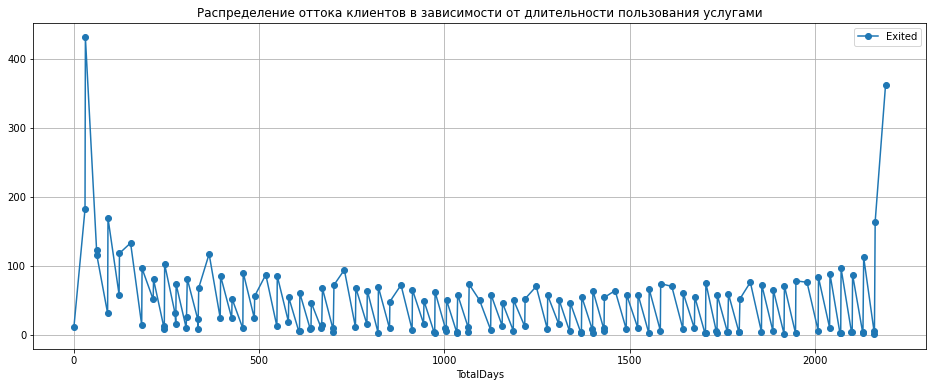

In [29]:
exited_df = df.pivot_table(values = 'Exited', index ='TotalDays', aggfunc='count').plot(style='o-', grid=True,figsize=(16, 6))
plt.title('Распределение оттока клиентов в зависимости от длительности пользования услугами')
plt.show()

Посмотрим на отток клиентов по годам

In [30]:
print(df['EndDate'].value_counts()) 

2020-02-01    5174
2019-11-01     485
2019-12-01     466
2020-01-01     460
2019-10-01     458
Name: EndDate, dtype: int64


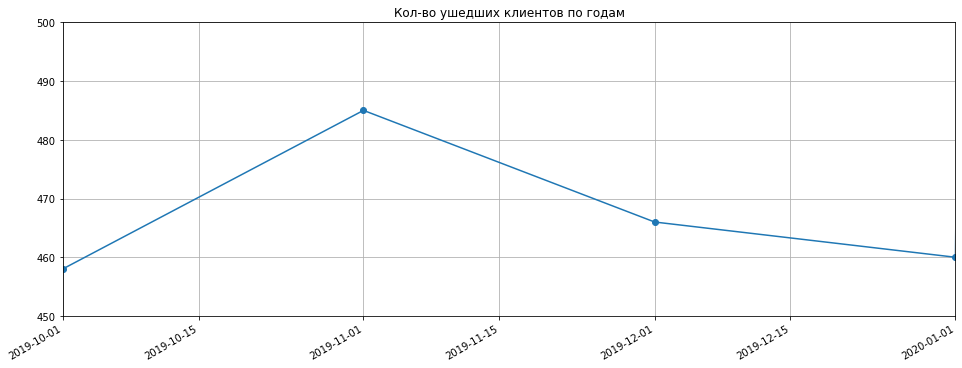

In [31]:
df['EndDate'].value_counts().plot(style='o-',xlim = ('2019-10-01', '2020-01-01'), ylim = (450, 500), grid=True,figsize=(16, 6))
plt.title("Кол-во ушедших клиентов по годам")
plt.show()

Вывод:
1) Была проведена предобработка данных: В стобцах BeginDate, EndDate, TotalCharges был изменен тип данных, а также заполнены пропуски. Были созданы 2 дополнительных столбца:
Exited - содержит информацию о том ушел клиент (1) или же еще пользуется услугами компании (0)
Month - содержит информацию о кол-ве месяцев, когда клиент являлся пользователем услуг компании.
2) Был проведен исследовательский анализ данных, на основании чего можно сделать следующие выводы: Доля клиентов, которые пользуются всеми услугами составляет 68.6%, клиенты которые пользуются только интрнетом составляют 21.7%, а 9,7% пользуются только телефоном. Что же касается ушедших клиентов, то здесь следующая статистика: всеми услугами пользовались 84.9%, услугами интернета - 9,1%, а телефоном 6%. Общая сумма оплат больше, если клиент пользуется всеми услугами, далее интернет, и меньше всего оплат за телефонную связь. Что же касается кол-ва новых клиентов, то здесь стоит отметить следующее: наблюдается резкий рост с начала 2014 года, затем резкий спад вплоть до мая 2014. И начиная с мая 2014 вплоть до декабря 2018 года, кол-во новых клиентов колеблится в диапазоне от 50 до 100, и начиная с 2019 года мы наблюдаем постепенный рост на протяжении всего года, и уже с января 2020 года опять резкий спад, вплоть до показателей конца 2013 года. Что же касается ушедших клиентов, исходя из графиков видно, что чаще всего расторгают договор новые клиенты, которые пользовались услугами всего пару месяцев. Исходя из данных, видно, что первый расторгнутый договор датируется октябрем 2019 года, и на протяжении всего месяца кол-во расторгнутых договоров только растет и начинают уходить и старые клиенты. И чаще всего расторгают договор клиенты, у которых ежемесячная оплата.

Посмотрим на матрицу корреляций, чтобы убедиться, что нет линейных зависимостей 

Удалим ненужные столбцы:
BeginDate, EndaDate - привязка ко времени 
customerID - уникальный идентификатор - лишний шум для наших моделей. 

In [33]:
df = df.drop(['customerID','BeginDate', 'EndDate'], axis=1)

In [34]:
interval_cols = ['MonthlyCharges', 'TotalCharges', 'TotalDays']
phik_overview = df.phik_matrix(interval_cols=interval_cols)

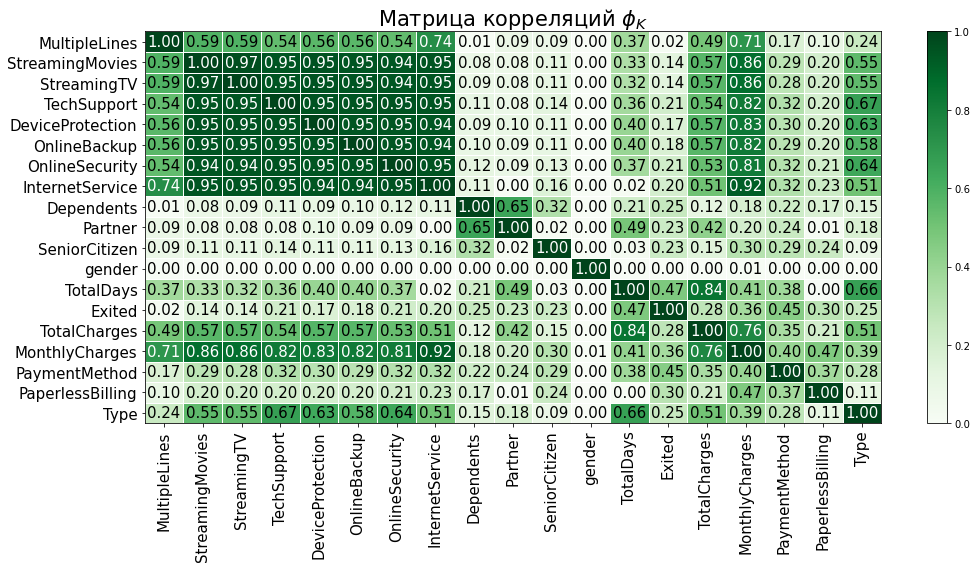

In [35]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"Матрица корреляций $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(15, 8))
plt.tight_layout()

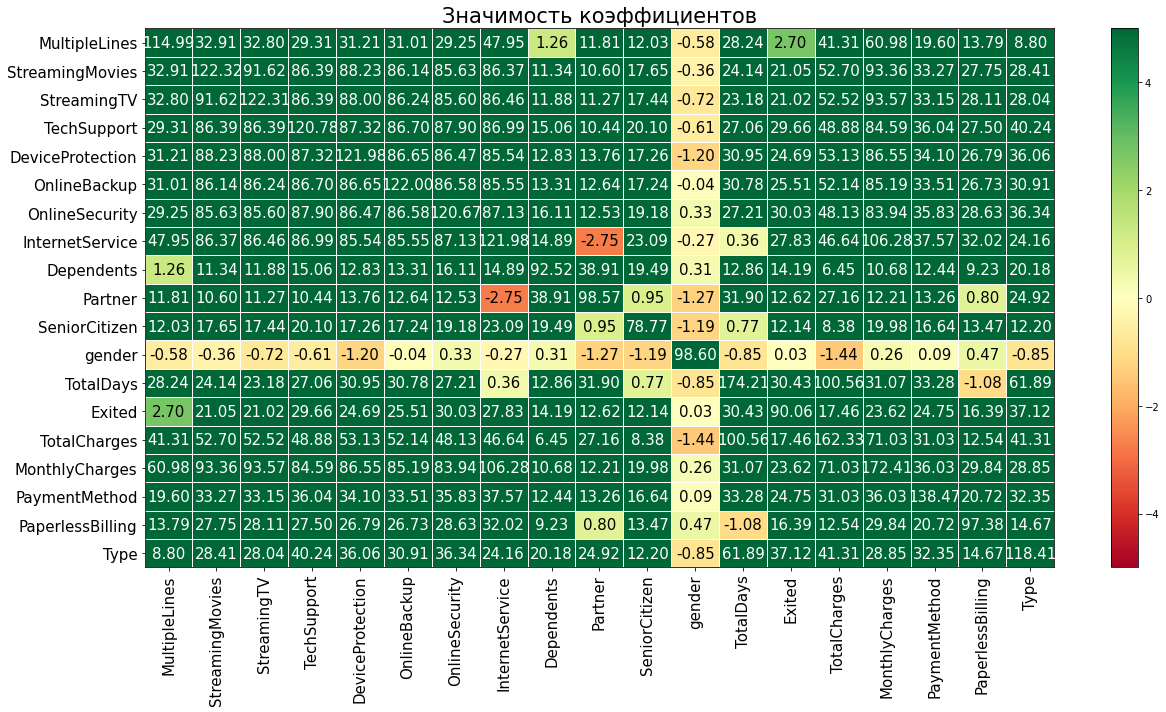

In [36]:
significance_overview = df.significance_matrix(interval_cols=interval_cols)
plot_correlation_matrix(significance_overview.fillna(0).values, 
                        x_labels=significance_overview.columns, 
                        y_labels=significance_overview.index, 
                        vmin=-5, vmax=5, title="Значимость коэффициентов", 
                        usetex=False, fontsize_factor=1.5, figsize=(18, 10))
plt.tight_layout()

Удалим ненужные столбцы:
TotalCharges - сильная корреляция с TotalDays,
Gender - вообще неинформативный столбец. 

In [37]:
df = df.drop(['TotalCharges','gender'], axis=1)

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   object 
 1   PaperlessBilling  7043 non-null   object 
 2   PaymentMethod     7043 non-null   object 
 3   MonthlyCharges    7043 non-null   float64
 4   Exited            7043 non-null   int64  
 5   TotalDays         7043 non-null   int64  
 6   SeniorCitizen     7043 non-null   int64  
 7   Partner           7043 non-null   object 
 8   Dependents        7043 non-null   object 
 9   InternetService   7043 non-null   object 
 10  OnlineSecurity    7043 non-null   object 
 11  OnlineBackup      7043 non-null   object 
 12  DeviceProtection  7043 non-null   object 
 13  TechSupport       7043 non-null   object 
 14  StreamingTV       7043 non-null   object 
 15  StreamingMovies   7043 non-null   object 
 16  MultipleLines     7043 non-null   object 


Перейдем к моделированию, но сперва проверим соотношение целевого признака.

In [39]:
rat = len(df.loc[df['Exited']==0])/len(df[df['Exited']==1])
rat

2.7683253076511503

Соотношение небольшое, но стоит это учесть в дальнейшем. 

### CatBoostClassifier

In [40]:
X = df.drop('Exited', axis=1)
y = df['Exited']

In [41]:
cat_features = X.columns[np.where(X.dtypes != float)[0]].values.tolist()
print(cat_features)

['Type', 'PaperlessBilling', 'PaymentMethod', 'TotalDays', 'SeniorCitizen', 'Partner', 'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']


In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=311022, stratify = df['Exited'])

In [43]:
%%time
pipe_CBC = Pipeline(
    [('clf', CatBoostClassifier(cat_features=cat_features, auto_class_weights='SqrtBalanced', random_state=311022, verbose=False))])

params_CBC = [{
    'clf__learning_rate' : [0.01, 0.04],
    'clf__iterations': [60, 80, 100, 200],
    'clf__depth': [4, 5, 6, 7, 8, 9, 10]
}]

model_CBC = GridSearchCV(estimator=pipe_CBC,
            param_grid=params_CBC,
            scoring='roc_auc',
            cv=5, 
            n_jobs=-1)
model_CBC.fit(X_train,y_train)

print(model_CBC.best_score_)
print(model_CBC.best_params_)

0.9525041863426956
{'clf__depth': 5, 'clf__iterations': 200, 'clf__learning_rate': 0.04}
CPU times: user 4.12 s, sys: 783 ms, total: 4.9 s
Wall time: 1min 15s


### SVM

Закодируем переменные

In [44]:
numeric_features = X_train.select_dtypes(exclude=['object']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()


numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)


categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)


In [45]:
def m_svm(trial):
    C = trial.suggest_float('C', 0.1, 1.)

    pipe = Pipeline(steps=[("preprocessor", preprocessor),
        
         ('clf', svm.SVC(C=C))]
    )
    
    scores = cross_val_score(pipe, X_train, y_train,
                             scoring='roc_auc',
                             n_jobs=-1)
    
    return scores.mean()

In [46]:
%%time
study_svm = optuna.create_study(direction='maximize', 
                                 sampler=sampler)
study_svm.optimize(m_svm, n_trials=15)

[I 2022-11-11 18:47:11,922] A new study created in memory with name: no-name-b9222145-8f61-43b4-b448-39c96ec1a312
[I 2022-11-11 18:47:13,579] Trial 0 finished with value: 0.8070459783594254 and parameters: {'C': 0.3205200172837339}. Best is trial 0 with value: 0.8070459783594254.
[I 2022-11-11 18:47:15,045] Trial 1 finished with value: 0.7999897503393623 and parameters: {'C': 0.9546469984776439}. Best is trial 0 with value: 0.8070459783594254.
[I 2022-11-11 18:47:16,369] Trial 2 finished with value: 0.8165784510138943 and parameters: {'C': 0.12020199418083821}. Best is trial 2 with value: 0.8165784510138943.
[I 2022-11-11 18:47:17,625] Trial 3 finished with value: 0.8097933722136907 and parameters: {'C': 0.25682498266968923}. Best is trial 2 with value: 0.8165784510138943.
[I 2022-11-11 18:47:19,024] Trial 4 finished with value: 0.8067782293146191 and parameters: {'C': 0.32755904909888556}. Best is trial 2 with value: 0.8165784510138943.
[I 2022-11-11 18:47:20,361] Trial 5 finished wit

CPU times: user 332 ms, sys: 36.9 ms, total: 369 ms
Wall time: 20.3 s


In [47]:
study_svm.best_value

0.8167283862860917

### Тестирование лушей модели (CatBoostClassifier)

AUC-ROC CatBoostClassifier 0.9577311194145933


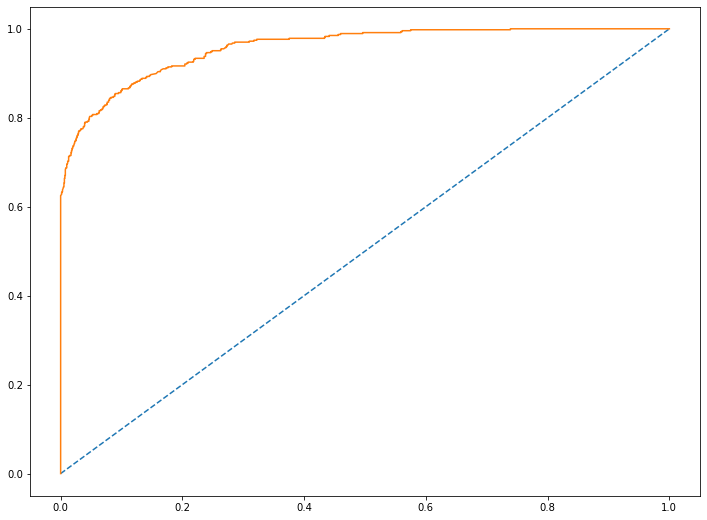

In [48]:
plt.figure(figsize=[12,9])

plt.plot([0, 1], [0, 1], linestyle='--', label='RandomModel')
probabilities_test = model_CBC.predict_proba(X_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_test)
auc_roc = roc_auc_score(y_test, probabilities_one_test)
print('AUC-ROC CatBoostClassifier',auc_roc)
plt.plot(fpr, tpr, label='CatBoostClassifier')

### Выводы
Задача проекта спрогнозировать отток клиентов. Нам были предоставлены исторические данные по клиентам.
Всего в нашем распоряжении 4 таблицы:
1) Contract (ct) Вcего 7043 строки и 8 столбцов. В таблице содержится следующая информация:

- customerID - идентификационный номер клиента
- BeginDate - дата начала пользования услугами
- EndDate - дата окончания окончания пользования услугами
- Type - тип срока оплаты (ежемесячно, раз в год, раз в два года)
- PaperlessBilling - тип выставления счета (бумажный или электронный)
- PaymentMethod - метод оплаты (Electronic check, Mailed check, Bank Transfer(automatic), Credit Card(automatic)
- MonthlyCharges - ежемесячная оплата
TotalCharges - общая сумма оплат

2) Internet (it) Всего 5517 строк и 8тстолбцов. В таблице содержится следующая информация:

- customerID - идентификационный номер клиента
- InternetService - тип интрнет подключения
- OnlineSecurity - блокировка небезопасных сайтов
- OnlineBackup - облачное храненилище файлов для резервного копирования данных
- DeviceProtection - интернет безопасность
- TechSupport -выделенная линия технической поддержки
- StreamingTV - стриминговое телевидение
- StreamingMovies - каталог фильмов

3) Personal (pl) Всего 7043 строк и 5 столбцов. В таблице содержится следующая информация:
- customerID - идентификационный номер клиента
- gender - пол
- SeniorCitizen - является ли клиент пенсионного возраста
- Partner - есть ли партнер
- Dependents - есть ли кто-то на иждивении

4) Phone (pe) Всего 6361 строка и 2 столбца. В таблице содержится следующая информация:

- customerID - идентификационный номер клиента
- MultipleLines - подключен ли телефонный аппарат к нескольким линиям одновременно.

Была написана функция для прверки, которая проверяла каждую таблицу по следующим параметрам:
- Общая информация (размер таблицы, тип данных в столбцах, кол-во значений в каждом столбце)
- вывод наэкран 10 первых строк таблицы
- вывод на экран статистических данных, которые дают представление о распределении значений
- вывод на экран кол-во уникальных значений и кол-во будликатов

После первичной проверки данных было обнаружено:
Пропусков нигде нет. В двух таблицах (Contract и Personal) одинаковое кол-во строк 7043, соответственно мы имеем данные о 7043-х клиентах компании. Кол-во клиентов, которые пользуются только услугами интрнет составляет 5517, а кол-во тех, кто пользуется услугами только телефонной связью составляет 6361. В столбцах с информацией о дате начала и конца пользвания услугами неверный тип данных, также странный тип данных в столбце TotalCharges.  ((((((Необходимо сделать предобработку данных:
В некоторых столбцах неверный тип данных, нужно изменить на правильный.
Стоит проверить данные на аномалии.)))))))
Так как перед нами стояла задача спргнозировать отток клиентов, было принято решение создасть дополнительный столбец с целевым признаком 'Exited', для этого была создана функция, которая проставляла 1 если в столбце EndDate не было записи и 0, если дата стояла. 
Далее мы проверили столбец TotalCharges на уникальность и вывели минимум на экран, так как там был тип данных object. Результатом оказалась пустая строка. После чего решили вывести на экран все строки с пустыми значениями в столбце TotalCharges, и увидели, что они все датируются 1 февраля 2020 года, дата на которую нам предоставили все данные, соответственно было принято решение заменить все пустые значения на 0, так как оплат в этом месяце еще не было. Далее изменили тип данных в данном столбце на числовой.
В столбце с датой окончания договора присутсвовал 'No'. Создали заглушку с датой актуальности данных: 01.02.2020
Изменили тип данных в столбцах BeginDate и EndDate.
Для дальнейших расчетов понадобился столбец с кол-вом дней, в течении кторорых клиент пользовался услугами компании, сделали расчети дабавили столбец в общую таблицу. Проверили как изменились данные, вывев на экран информацию по таблице. Далее объединили все 4 таблицы в одну.К общей тадлице применили функцию для вывода информации и выявили, что после объединения образовались пропуски, что вполне логично, потому что есть клиенты, которые использует либо только телефонию, либо только интернет. Заменили пропуски на 'NS' - No Service
Для удобства в дальнейшем создали списки с категориальными и числовыми столбцами
Построили графики распределения по категориальным данным(тип оплаты, метод оплаты, пол, является ли клиент пенсионером).
Было выявлено:
По полу примерно одинаковое распределение, пенсионеров среди пользователей гораздо меньше, ежемесячная оплата самая популярная, гораздо больше пользователей предпочитают электронный чек, меньше всего автоматическая оплата кредитной картой, по интернету популарна линия fiber opric, совсем не популярна NS.
Далее построили графики по категориальным данным по ушедшим и оставшимся клиентам: 
Среди ушедших клиентов большинство предпочитали ежемесячную оплату, бумажный счет, электронный чек.
Пол никак не вляет. Интрнет fiber optic больше популярен у ушедших клиентов. Так же ушли те ,у которых не было доп. опций по интернету.
Далее построили график по кол-ву новых клиентов компании по годам. А также кол-во новых клиентов компании с 2019 года. Построили график оттока клиентов (заисимость от длительности пользования услугами), а также посмотрели на кол-во ушедших клиентов по датам, выявили что начали уходить с октября 2019, построили график с кол-вом ушедших клиентов по датам начиная с октября 2019 по 1 февраля 2020 года. 
На основании полученной информации сделали предварительный вывод:
Доля клиентов, которые пользуются всеми услугами составляет 68.6%, клиенты которые пользуются только интрнетом составляют 21.7%, а 9,7% пользуются только телефоном. Что же касается ушедших клиентов, то здесь следующая статистика: всеми услугами пользовались 84.9%, услугами интернета - 9,1%, а телефоном 6%. Общая сумма оплат больше, если клиент пользуется всеми услугами, далее интернет, и меньше всего оплат за телефонную связь. Что же касается кол-ва новых клиентов, то здесь стоит отметить следующее: наблюдается резкий рост с начала 2014 года, затем резкий спад вплоть до мая 2014. И начиная с мая 2014 вплоть до декабря 2018 года, кол-во новых клиентов колеблится в диапазоне от 50 до 100, и начиная с 2019 года мы наблюдаем постепенный рост на протяжении всего года, и уже с января 2020 года опять резкий спад, вплоть до показателей конца 2013 года. Что же касается ушедших клиентов, исходя из графиков видно, что чаще всего расторгают договор новые клиенты, которые пользовались услугами всего пару месяцев. Исходя из данных, видно, что первый расторгнутый договор датируется октябрем 2019 года, и на протяжении всего месяца кол-во расторгнутых договоров только растет и начинают уходить и старые клиенты. И чаще всего расторгают договор клиенты, у которых ежемесячная оплата.
Далее удалили ненужные столбцы: BeginDate, EndaDate - привязка ко времени customerID - уникальный идентификатор - лишний шум для наших моделей. Затем построили матрицу корреляций и проверили занчимость коэффициентов, удалили еще столбцы TotalCharges - сильная корреляция с totaldays, Gender - вообще неинформативный столбец.
Проверили соотношение целевого признака - 2.7683253076511503.
Соотношение небольшое, но учли это в создании моделей.
Создали переменные с целевым признаком и фичами. 
Отфильтровали категориальные фичи
Разбили датасет на тестовую и обучающую выборки с учетом равномерного распределения целевого признака
Начали построение модели CatBoostClassifier. В коробку занесли категориальные признаки, поставили баланс классов. Подбор гиперпараметров осуществили с помощью GridSearchCV, обучили модель и вывели на экран лучший показатель и набор гиперпараметров. 
Решили проверить еще и SVM, создали численные фичи и категориальные, числовые преобразовали с помощью StandartScaler, а категориальные заодировали с помощью OneHotEncoder, опять же в коробке, подбор гиперпараметров осуществили с помощью optuna.  
Обучили модель, но результат (roc_auc = 0.81) оказался хуже чем у CatBoost( roc_auc = 0.95).
Провели тестирование лучей модели и получили результат в 0.95.